In [3]:
from __future__ import division

import numpy as np
from scipy.stats import nbinom, poisson, beta
from math import log, exp, log10, floor, sqrt

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set(style="white", palette="deep", color_codes=True)
sns.set_context("notebook", font_scale=1.2)

def force_aspect(ax, aspect=1):
    """force a matplotlib axis to have the specified aspect ratio on the screen"""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    a = (np.max(xlim) - np.min(xlim)) / (np.max(ylim) - np.min(ylim))
    ax.set_aspect(a / aspect)
    
golden_ratio = 1.61803398875

In [4]:
import pickle
import glob
import re

# Introduction

I reworked the MCMC simulation to simultaneously fit for Madison and Hamilton.  I add a prior for the parameter $\tau = \mu_{\mathrm{M}}/(\mu_{\mathrm{H}}+\mu_{\mathrm{M}})$, and just borrowed the same beta-distribution that Mosteller & Wallace assumed.  I don't expect this choice matters much, provided that it penalizes values of $\tau$ which are either very close to 0 or very close to 1.

This code is essentially the same, and since it's too slow to run in the notebook in any case, I won't show it here... if you like, you can check out coupled-mcmc.py in the gcloud/ directory.  In this notebook, we'll just look at the results, borrowing the analysis from the last notebook:

In [9]:
from scipy.stats import beta
from collections import Counter

In [10]:
def process_error(errorfile):
    # errorfile produced by 'check-errors.py' or 'check-errors-coupled.py'
    # - format is a 4xn array, where n is the total number of fragments checked
    # - rows are madison fragment length, madison result,
    #   hamilton fragment length, hamilton result
    # - for the results, a positive number indicates a correct determination
    #   and a negative number signals a misidentification.  magnitude is the
    #   quoted log-probability
    #
    with open(errorfile, 'rb') as f:
        mlen, mresults, hlen, hresults = pickle.load(f)
        
    # split into correct and incorrect determinations
    #
    allresults = np.concatenate([mresults, hresults])
    correct   = allresults[np.where(allresults > 0)]
    incorrect = allresults[np.where(allresults < 0)] * -1

    # tally correct and incorrect results as a function of predicted log odds,
    # flooring the log-odds to an integer
    #
    inc = Counter(np.floor(incorrect).astype(int))
    cor = Counter(np.floor(  correct).astype(int))
    
    all_odds_obtained = set(cor.elements()) | set(inc.elements())
    
    # empirical correct fraction
    correct_frac = [ cor[odds] / (cor[odds] + inc[odds])
                     for odds in all_odds_obtained ]

    # estimate the uncertainty in the success fraction:
    #
    # you can use Bayesian statistics to infer an error interval
    # the probability for the "true" success rate, based on an observation
    # of s successes and f failures, is a beta distribution.  no need to go
    # into the details here, but you can see the formula on this wiki page:
    # https://en.wikipedia.org/wiki/Checking_whether_a_coin_is_fair
    #
    # plot the 95% confidence interval:
    intervals = [ beta(cor[odds]+1, inc[odds]+1).interval(0.95) 
                  for odds in all_odds_obtained ]

    medians   = [ beta(cor[odds]+1, inc[odds]+1).median()
                  for odds in all_odds_obtained ]
    
    ret = [ (odds, frac, median, median-interval[0], interval[1]-median)
           for odds, frac, median, interval 
           in zip(all_odds_obtained, correct_frac, medians, intervals) ]
    
    # transpose and return
    return np.asarray(ret).T

In [11]:
def histogram_study(errfile, odds_reduction=1.0):

    odds, frac, med, err_m, err_p = process_error(errfile)

    def my_histogram(odds, frac, ax):
        """custom histogram plot to show successes and failures"""
        # first define some colors
        pal = sns.color_palette("RdBu", n_colors=7)
        fail_color, missing_color, success_color = pal[0], pal[5], pal[6]

        # plot successful inferences
        ax.bar(odds, frac,
               color=success_color, width=1, align='edge')

        # plot failed inferences
        ax.bar(odds, 1.0-frac, bottom=frac,
               color=fail_color, width=1, align='edge')

        # plot missing data
        missing = set(np.arange(np.max(odds))) - set(odds)
        ax.bar(list(missing), [1.0] * len(missing),
               color=missing_color, width=1, align='edge')

    # make a 2x2 plot
    #
    fig=plt.figure(figsize=(12, 12))
    gs=GridSpec(1,2) # two rows, two columns

    ax1=fig.add_subplot(gs[0,0])
    ax2=fig.add_subplot(gs[0,1])

    my_histogram(odds, frac, ax1)

    ax1.errorbar(odds+0.5, med, yerr=[err_m, err_p],
                 fmt='o', marker=None, color='0.15', elinewidth=3)

    ax1.set_ylim([0.0,  1.0]);
    ax1.set_xlim([0.0, 10.0]);

    # plot the implied success fraction, based on the inferred log-odds
    # reduce the odds by an optional factor odds_reduction
    x = np.linspace(0.5, 10.0, 50)
    y = 1.0 / (1.0 + np.exp((x-0.5) / odds_reduction))
    ax1.plot(x, 1.0-y, color='0.75', linewidth=4)

    ax1.set_xlabel('log odds')
    ax1.set_ylabel('correct fraction')
    #ax1.legend(loc=4)


    # next, re-plot the histogram over a wider range of data, mostly so that we
    # can see a lot of successes and then feel good about ourselves
    my_histogram(odds, frac, ax2)

    ax2.set_ylim([0.0,1.0]);
    ax2.set_xlim([0.0, 60.0]);

    ax2.set_xlabel('log odds')
    ax2.set_ylabel('correct fraction');

    force_aspect(ax1, golden_ratio)
    force_aspect(ax2, golden_ratio)

    plt.show()

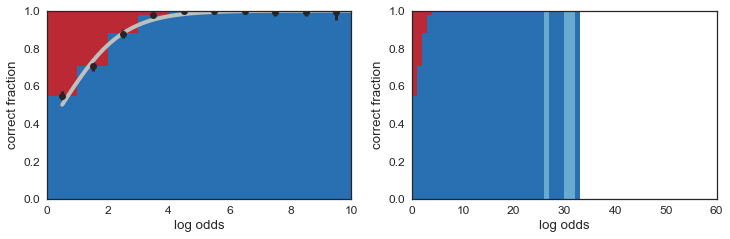

In [26]:
# trained on full set of known federalist papers... overlaps with test data!
histogram_study('gcloud/errors/full-set-overlap_coupled.pickle')

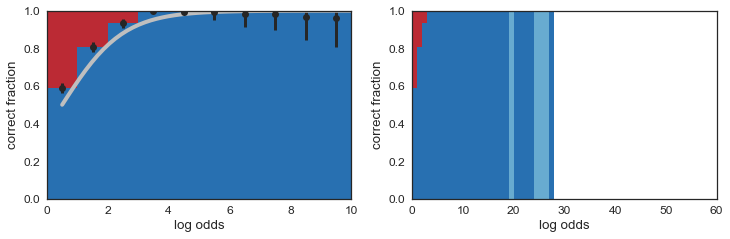

In [25]:
# training set of ~40k words, testing set of ~25k words, no overlap
histogram_study('gcloud/errors/large-training-set-no-overlap_coupled.pickle')

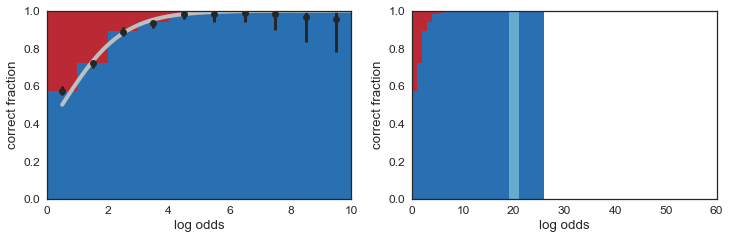

In [24]:
# training set of ~25k words, testing set of ~40k words, no overlap
histogram_study('gcloud/errors/small-training-set-no-overlap_coupled.pickle')

You can see that the model performs less well in the sense that it reports *vastly* lower certainty.  But on the other hand, it's never wrong when it says its certain... and that's the entire point.  It's nice to feel certain, but it's even better to be right.

(this agreement is quite amazing, by the way... it's nice to see things work out as they should!)

Now that we're finally certain of the *accuracy* of the model, we can take a look at its *sensitivity*.  To measure this, I'll find the typical fragment length needed to give 3:1 odds, 150:1 odds, and 22,000:1 odds:

In [6]:
def plot_certainty(errorfile, ax):

    with open(errorfile, 'rb') as f:
        mlen, mresults, hlen, hresults = pickle.load(f)

    allresults = np.concatenate([mresults, hresults])
    alllens    = np.concatenate([mlen, hlen])
    
    # hack because i changed the way i calculate this data...
    #if np.min(alllens) == 100:
    #    fragment_lengths = np.logspace(log10(100), log10(20000), 20)
    #    fragment_lengths = np.round(fragment_lengths).astype(int)
    #else:
    fragment_lengths = np.logspace(log10(50), log10(10000), 20)
    fragment_lengths = np.round(fragment_lengths).astype(int)
    
    odds = np.zeros((len(fragment_lengths), 8))
    
    for i in np.arange(1, len(fragment_lengths)):
        bmin, bmax = fragment_lengths[i-1], fragment_lengths[i]
        
        tmp = [ res for res, l in zip(allresults, alllens) 
                if l <= bmax and l > bmin ]
        odds[i,1:] = np.percentile(tmp, (0, 5, 25, 50, 75, 95, 100))
        odds[i,0] = sqrt(bmin*bmax)
        
    odss = odds[1:,:]
        
    pal = sns.color_palette("Blues", 3)

    ax.fill_between(odds[:,0], odds[:,1], odds[:,7], color=pal[0], label='full range')
    ax.fill_between(odds[:,0], odds[:,2], odds[:,6], color=pal[1], label=' 90% range')
    ax.fill_between(odds[:,0], odds[:,3], odds[:,5], color=pal[2], label=' 50% range')
    ax.plot(odds[:,0], odds[:,4], '-', color='85', linewidth=3, label='median')

    ax.axhline(y=1.0,  color='k')
    ax.axhline(y=5.0,  color='k')
    ax.axhline(y=10.0, color='k')
    
    ax.set_xscale('log')

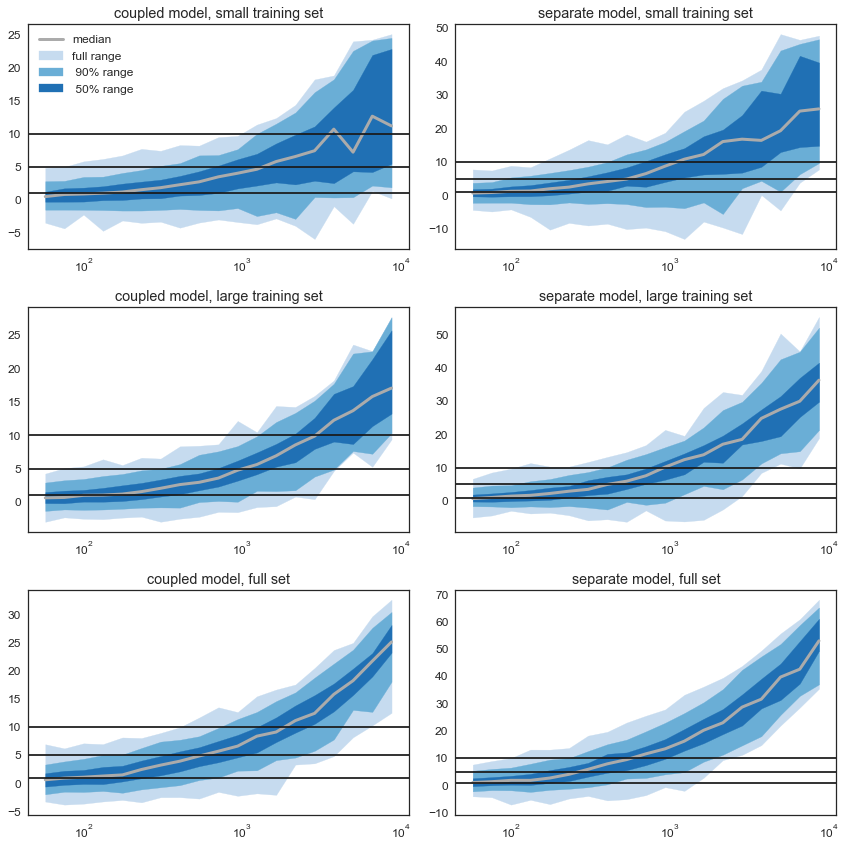

In [7]:
fig=plt.figure(figsize=(12, 12))
gs=GridSpec(3,2) # two rows, two columns

ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[1,0])
ax5=fig.add_subplot(gs[2,0])

ax3=fig.add_subplot(gs[0,1])
ax4=fig.add_subplot(gs[1,1])
ax6=fig.add_subplot(gs[2,1])

plot_certainty('gcloud/errors/small-training-set-no-overlap_coupled.pickle', ax1)
ax1.set_title('coupled model, small training set');
ax1.legend(loc='upper left');
plot_certainty('gcloud/errors/large-training-set-no-overlap_coupled.pickle', ax2)
ax2.set_title('coupled model, large training set');
plot_certainty('gcloud/errors/full-set-overlap_coupled.pickle', ax5)
ax5.set_title('coupled model, full set');

plot_certainty('gcloud/errors/small-training-set-no-overlap.pickle', ax3)
ax3.set_title('separate model, small training set');
plot_certainty('gcloud/errors/large-training-set-no-overlap.pickle', ax4)
ax4.set_title('separate model, large training set')
plot_certainty('gcloud/errors/full-set-overlap.pickle', ax6)
ax6.set_title('separate model, full set');

fig.tight_layout()

You can see that we get *much* lower certainties with the coupled model... for a typical 1000 word fragment, our certainty has gone from $\exp(10) \sim$ 22,000:1 to $\exp(5)\sim$ 150:1.  This may be partly because I'm not making full use of the available information, and I do think there's still room to improve.  But most of the decrease simply comes from the fact that we're now being honest about our confidence... and it shows in the histogram plots above.

Nonetheless, 1000 words is typically enough to assign 150:1 odds for Madison or Hamilton, 2000-3000 words is enough to give 22,000:1 odds.  Since almost all of the Federalist papers are in this range, this model is sensitive enough for our purposes.  And it's great to know that we can trust the odds it quotes!

Interestingly, you'll see that in rare cases, we can assign a high probability to fragments as small as 300-500 words -- these turn out to be fragments with high incidences of clear maker words such as *upon*, *whilst*, and *while*.  Such words are so rare that we can't rely on them to make all of our determinations, but when they do occur they're very powerful!

# Now, we're finally ready to determine the authors of the disputed papers!

In [104]:
import nltk
from collections import Counter

In [105]:
stopwords = ["a", "about", "above", "according", "across", "affect", "after", \
"again", "against", "all", "almost", "alone", "along", "already", \
"also", "although", "always", "among", "an", "and", "another", "any", \
"anyone", "anything", "anywhere", "apt", "are", "argue", "around", \
"as", "asserted", "at", "back", "be", "became", "because", "become", \
"becomes", "been", "before", "behind", "being", "better", "between", \
"both", "but", "by", "can", "cannot", "common", "commonly", \
"comparable", "consequently", "considerable", "could", "course", \
"degree", "did", "do", "done", "down", "dramatically", "during", \
"each", "either", "enough", "even", "ever", "every", "everyone", \
"everything", "everywhere", "extent", "few", "find", "first", \
"follow", "for", "four", "from", "full", "further", "get", "give", \
"go", "had", "has", "have", "he", "hence", "her", "here", "herself", \
"him", "himself", "his", "how", "however", "if", "imply", \
"importance", "in", "interest", "into", "is", "it", "its", "itself", \
"join", "keep", "kind", "largely", "last", "least", "less", "made", \
"many", "may", "me", "might", "more", "moreover", "most", "mostly", \
"much", "must", "my", "myself", "necessary", "never", "next", "no", \
"nobody", "noone", "nor", "not", "nothing", "now", "nowhere", "of", \
"off", "often", "on", "once", "one", "only", "or", "other", "others", \
"our", "out", "over", "part", "particularly", "per", "perhaps", \
"possible", "principle", "put", "rather", "requisite", "same", \
"second", "see", "seem", "seemed", "seeming", "seems", "several", \
"shall", "she", "should", "show", "side", "since", "so", "some", \
"someone", "something", "somewhere", "still", "substance", "such", \
"suggest", "take", "than", "that", "the", "their", "them", "then", \
"there", "therefore", "these", "they", "thing", "this", "those", \
"though", "three", "through", "throughout", "thus", "to", "together", \
"too", "toward", "two", "typical", "typically", "under", \
"unexpected", "until", "up", "upon", "us", "use", "using", "very", \
"was", "we", "well", "were", "what", "when", "where", "whether", \
"which", "while", "whilst", "who", "whole", "whose", "why", "will", \
"with", "within", "without", "would", "yet", "you", "your", "yours"]

In [117]:
# functions to calculate probability -- these happen on worker processes
#
def prob(x, num, sample):
    """log-probability for a single word to occur x times in a text
    of length num words, given author model defined by the MCMC
    chain in sample"""
    sample = sample
    ps =  np.zeros(len(sample))
    
    for i, theta in enumerate(sample):
        lam, f = np.exp(theta)
        lam = lam * (num/1000) # scale predicted rate to text length
        
        n = lam / f
        p = 1.0 / (1.0 + f)
        ps[i] = nbinom.pmf(x, n, p)

    return log(np.mean(ps))


def measure(text):
    """tally the occurrcences of each of the stopwords in text"""
    c = Counter(text)
    x = [ c[w] for w in stopwords ]

    return (x, len(text))


def all_prob(obs, model1, model2):
    """given a sample of text, along with two author models,
    return the difference in log-probabilities for each of the
    authors.  (equivalently, this is the log of the ratio of
    probabilities that each author wrote it.)"""
    xs, num = obs

    m1 = np.sum([prob(x, num, sample) for x, sample in zip(xs, model1)])
    m2 = np.sum([prob(x, num, sample) for x, sample in zip(xs, model2)])

    return m1-m2

def read_coupled_model(filename):
    """read in the MCMC chain for a coupled model and split into
    separate chains for madison and for hamilton."""
    with open(filename, 'rb') as handle:
        model = pickle.load(handle)

    model = np.asarray(model)
    m_model = model[:,:,:2]     # shape: words, samples, parameters
    h_model = model[:,:,2:]

    return (m_model, h_model)

In [113]:
m_model, h_model = read_coupled_model('gcloud/author-models/coupled-all.pickle')

In [114]:
def measure(filename):
    with open(filename, 'r') as f:
        raw = f.read()

    all_words = nltk.word_tokenize(raw.lower())
    num = len(all_words)

    c = Counter(all_words)
    x = [ c[w] for w in stopwords ]
    
    return (x, num)

u = [ measure(f) for f in glob.glob('../authors/unknown-federalist/*.txt') ]

In [115]:
import re
names = [ re.sub(r'.*?([0-9]+).*', r'\1', f) 
         for f in glob.glob('../authors/unknown-federalist/*.txt') ]

In [118]:
%%timeit -n 1 -r 1
u_results = [ all_prob(obs, m_model, h_model) for obs in u ]

print "Disputed Papers:"
print "Positive if Madison wrote them, negative if Hamilton:"
print np.round(u_results, 1)

Disputed Papers:
Positive if Madison wrote them, negative if Hamilton:
[ 14.3  13.3   9.4   4.8   4.4  10.9   6.5   8.6   5.1   0.5   7.6   6.4
   6.9   7.6]
1 loop, best of 1: 12min 33s per loop


In [123]:
def format_integer(x):
    """Round an integer to two significant digits"""
    cut = int(floor(log10(abs(x))))-1
    ret = int(round(x, -cut))
    return format(ret, ",d")

def print_odds(d):
    """Convert d, the differnce in log-likelihood (or equivalently, the 
    log of the odds ratio), return a string indicating the conventional
    odds ratio"""
    if d>0:
        return "{0:s}:1".format(format_integer(exp(d)))
    else:
        return "1:{0:s}".format(format_integer(exp(-d)))

In [127]:
for name, res in zip(names, u_results):
    print "Federalist #{0:s}: {1: >12s} odds for Madison".format(name, print_odds(res))

Federalist #18:  1,600,000:1 odds for Madison
Federalist #19:    600,000:1 odds for Madison
Federalist #20:     12,000:1 odds for Madison
Federalist #49:        120:1 odds for Madison
Federalist #50:         81:1 odds for Madison
Federalist #51:     54,000:1 odds for Madison
Federalist #52:        670:1 odds for Madison
Federalist #53:      5,400:1 odds for Madison
Federalist #54:        160:1 odds for Madison
Federalist #55:          1:1 odds for Madison
Federalist #56:      2,000:1 odds for Madison
Federalist #57:        600:1 odds for Madison
Federalist #62:        990:1 odds for Madison
Federalist #63:      2,000:1 odds for Madison


These are *substantially* weaker results!  It may be that this model is *too* conservative, and we can go back and try to make better use of the available information.  But I also think it's telling that, with every improvement to the model, the quoted odds have decreased signficantly every time.  This is the first model which I can confidently say does not overstate the odds (though it may well understate them), and for many of the papers the result has dimished appreciably.  The evidence still tilts in Madison's favor, perhaps even strongly, but it's not nearly the slam-dunk that Mosteller and Wallace had found in their earlier analysis.

At first, this is all a little disappointing.  But we saw how similar Hamilton and Madison are, and we know how little data there is to work with, and how sensitive it is to noise.  And there's also good historical evidence that Federalist #55 is contaminated with text from a 3rd author, such that it doesn't meet the assumptions in my model.

While it's possible that some of this loss of certainty stems from not taking full advantage of the data, I think most of it comes from simply being honest about the analysis.  So unfortunately I think it's very reasonable that we shouldn't be able to make such iron-clad determinations using this method, rountinely finding million-to-one odds for such similar authors, from fragments of text as short as 500 words.  Considering that, 100:1 odds does not seem bad at all... especially since we can believe them!

## try it again with a more stringent model:

I do think my model is pretty conservative... that was my goal, after all!  That may mean there's some opportunity to juice the model, squeezing a little more certainty out of it without sacrificing correctness.  There are a number of ways one might try this, and in general it would take some experimentation... I'll try going about it by re-running the models with a smaller denominator in the likelihood function.  My (unconfirmed!) intuition is that the tails of the distribution matter immensely, so I'll go about this by raising the denominator to some power... let's try 1.5.  (This is in fact what I plotted in the previous notebook; by eye, the results seem pretty reasonable...)

We first make sure this doesn't break the robustness of the model:

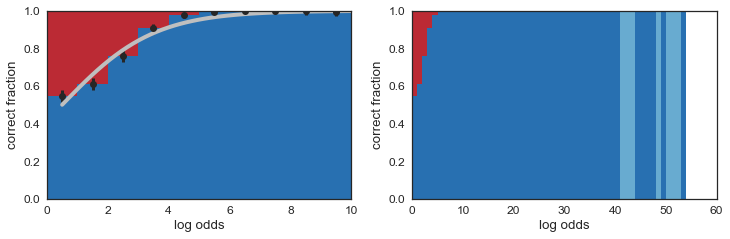

In [43]:
# full training set.  overlaps with the test data!
histogram_study('gcloud/errors/full-set-overlap_coupled_1.5.pickle', 1.5)

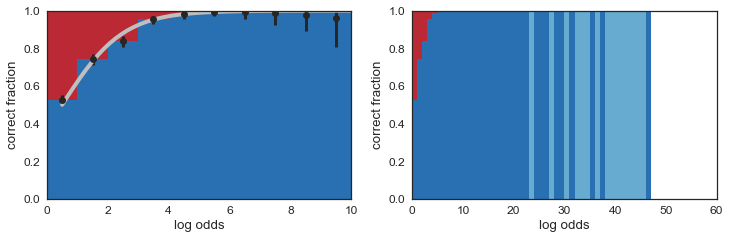

In [38]:
# training set of ~40k words, testing set of ~25k words, no overlap
histogram_study('gcloud/errors/large-training-set-no-overlap_coupled_1.5.pickle')

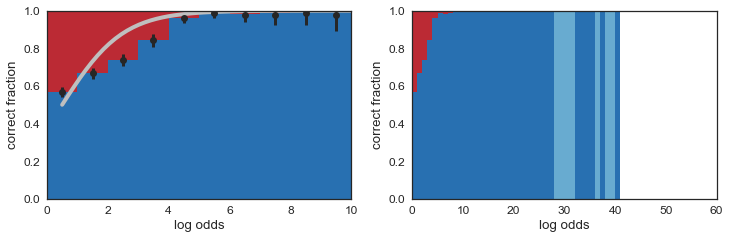

In [12]:
# training set of ~25k words, testing set of ~40k words, no overlap
histogram_study('gcloud/errors/small-training-set-no-overlap_coupled_1.5.pickle')

This last one is not great.  However, if we depreciate the odds by a factor of $\sim{1.75}$, then the results look pretty reasonable:

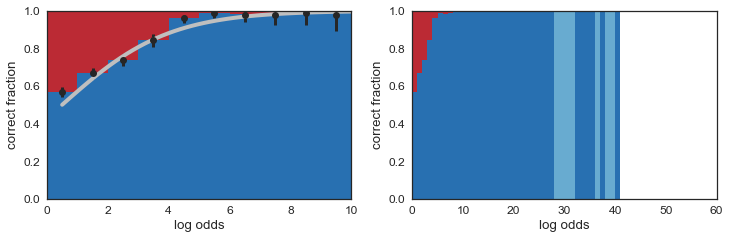

In [14]:
# training set of ~25k words, testing set of ~40k words, no overlap
histogram_study('gcloud/errors/small-training-set-no-overlap_coupled_1.5.pickle',
                odds_reduction=1.75)

eh, this new model is probably OK if you depreciate the odds by a factor of anywhere from 1.5 to 1.75... and it may well be that even these depreciated odds are stronger than what we get from the fiducial model.  I'm more comfortable with the fiducial model, but we can hang on to this one as well in case we need it to settle an argument:

In [33]:
m_model, h_model = read_coupled_model('gcloud/author-models/coupled-all_1.5.pickle')

In [34]:
u_results = [ all_prob(obs, m_model, h_model) for obs in u ]

print "Disputed Papers:"
print "Positive if Madison wrote them, negative if Hamilton:"
print np.round(u_results, 1)

Disputed Papers:
Positive if Madison wrote them, negative if Hamilton:
[ 22.1  18.8  12.8   7.1   6.4  16.6   9.9  14.    8.    2.4  10.7   8.3
  11.2  12.6]


In [44]:
for name, res in zip(names, u_results):
    print "Federalist #{0:s}: {1:s}".format(name, print_odds(res/1.75))

Federalist #18: 300,000:1
Federalist #19: 47,000:1
Federalist #20: 1,500:1
Federalist #49: 58:1
Federalist #50: 39:1
Federalist #51: 13,000:1
Federalist #52: 290:1
Federalist #53: 3,000:1
Federalist #54: 97:1
Federalist #55: 3:1
Federalist #56: 460:1
Federalist #57: 110:1
Federalist #62: 610:1
Federalist #63: 1,300:1


I think this is the best I can do for now.  The next notebook compares results from the various methods I explored and summarizes.